In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
class PolicyGradientAgent:
    def __init__(self, hidden_size=200, batch_size=10, learning_rate=1e-4, gamma=0.99, decay_rate=0.99, resume=False):
        # setup all the initial variables and stuff
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.decay_rate = decay_rate
        self.resume = resume
        self.input_dim = 80 * 80  # this is just the size of the input image but flattened

        # load the model from file if we're resuming, otherwise start fresh
        if self.resume:
            self.model = pickle.load(open('save.p', 'rb'))
        else:
            self.model = {
                'W1': np.random.randn(self.hidden_size, self.input_dim) / np.sqrt(self.input_dim),
                'W2': np.random.randn(self.hidden_size) / np.sqrt(self.hidden_size),
            }

        # these help with the math later on
        self.grad_buffer = {k: np.zeros_like(v) for k, v in self.model.items()}
        self.rmsprop_cache = {k: np.zeros_like(v) for k, v in self.model.items()}

    def preprocess(self, I):
        """ crunch down the input frame from the game to something more manageable """
        I = I[35:195]  # chop off the top and bottom of the image
        I = I[::2, ::2, 0]  # downsample by half in both dimensions
        I[I == 144] = 0  # remove the background color 1
        I[I == 109] = 0  # and background color 2
        I[I != 0] = 1  # everything else gets set to 1
        return I.astype(np.float32).ravel()

    def discount_rewards(self, rewards):
        """ take the rewards and make them more valuable the closer they are to now, cause we care more about the present, right? """
        discounted = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(len(rewards))):
            if rewards[t] != 0:
                running_add = 0 
            running_add = running_add * self.gamma + rewards[t]
            discounted[t] = running_add
        return discounted

    def forward(self, x):
        """ do the forward pass and figure out what action we should take """
        h = np.dot(self.model['W1'], x)
        h[h < 0] = 0  # ReLU nonlinearity
        raw_outputs = np.dot(self.model['W2'], h)
        p = 1.0 / (1.0 + np.exp(-raw_outputs))  # squash it to [0,1] (sigmoid function)
        return p, h  # gives us the probability of taking action and the hidden state

    def backward(self, eph, epd_raw_output, epx):
        """ backprop to adjust our weights, cause we gotta learn from what happened """
        dW2 = np.dot(eph.T, epd_raw_output).ravel()
        dh = np.outer(epd_raw_output, self.model['W2'])
        dh[eph <= 0] = 0  # again, negative vibes rule doesn't apply here
        dW1 = np.dot(dh.T, epx)
        return {'W1': dW1, 'W2': dW2}


    def train(self, env, render=False):
        # let's get this party started
        observation = env.reset()[0]
        prev_x = None
        xs, hs, d_raw_output_s, drs = [], [], [], []
        reward_sum = 0
        episode_number = 0

        while True:
            if render:
                env.render()

            # preprocess the observation, set input to network to be difference image
            cur_x = self.preprocess(observation)
            self.test1 = observation
            self.test = cur_x
            x = cur_x - prev_x if prev_x is not None else np.zeros(self.input_dim)
            prev_x = cur_x

            # Forward the policy network and sample an action from the returned probability
            aprob, h = self.forward(x)
            action = 2 if np.random.uniform() < aprob else 3  # Roll the dice!

            # Record various intermediates (needed later for backprop)
            xs.append(x)
            hs.append(h)
            y = 1 if action == 2 else 0
            d_raw_output_s.append(y - aprob)

            # Step the environment and get new measurements
            observation, reward, done, info, _ = env.step(action)
            reward_sum += reward
            drs.append(reward)

            if done:  # An episode finished
                episode_number += 1

                # Stack together all inputs, hidden states, action gradients, and rewards for this episode
                epx = np.vstack(xs) # 80x80x4
                eph = np.vstack(hs) 
                epd_raw_output = np.vstack(d_raw_output_s)
                epr = np.vstack(drs)
                xs, hs, d_raw_output_s, drs = [], [], [], []  # Reset array memory

                # Compute the discounted reward backwards through time
                discounted_epr = self.discount_rewards(epr)
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)

                epd_raw_output  *= discounted_epr
                grad = self.backward(eph, epd_raw_output , epx)
                for k in self.model:
                    self.grad_buffer[k] += grad[k]

                # Perform RMSProp parameter update every batch_size episodes
                if episode_number % self.batch_size == 0:
                    for k, v in self.model.items():
                        g = self.grad_buffer[k]
                        self.rmsprop_cache[k] = self.decay_rate * self.rmsprop_cache[k] + (1 - self.decay_rate) * g**2
                        self.model[k] += self.learning_rate * g / (np.sqrt(self.rmsprop_cache[k]) + 1e-5)
                        self.grad_buffer[k] = np.zeros_like(v)

                # Log details
                if reward != 0:
                    print(f'Episode {episode_number}: game finished, reward: {reward}' + (' !!!!!!!!' if reward > 0 else ''))

                if episode_number % 100 == 0:
                    pickle.dump(self.model, open('save.p', 'wb'))

                print(f'Episode {episode_number}: running reward: {reward_sum}')

                reward_sum = 0
                observation = env.reset()[0]  # Reset environment
                prev_x = None




In [3]:
for i in reversed(range(1,10)):
    print(i)

9
8
7
6
5
4
3
2
1


In [4]:
env = gym.make("Pong-v4", mode=1)#, render_mode="human")
agent = PolicyGradientAgent(resume=True)
agent.train(env, render=False)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/mattraghu/Documents/Projects/Spring2024/.venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: game finished, reward: -1.0
Episode 1: running reward: -11.0
Episode 2: game finished, reward: -1.0
Episode 2: running reward: -16.0
Episode 3: game finished, reward: -1.0
Episode 3: running reward: -14.0
Episode 4: game finished, reward: -1.0
Episode 4: running reward: -15.0
Episode 5: game finished, reward: -1.0
Episode 5: running reward: -9.0
Episode 6: game finished, reward: -1.0
Episode 6: running reward: -9.0
Episode 7: game finished, reward: -1.0
Episode 7: running reward: -19.0
Episode 8: game finished, reward: -1.0
Episode 8: running reward: -14.0
Episode 9: game finished, reward: -1.0
Episode 9: running reward: -10.0
Episode 10: game finished, reward: -1.0
Episode 10: running reward: -15.0
Episode 11: game finished, reward: -1.0
Episode 11: running reward: -13.0
Episode 12: game finished, reward: -1.0
Episode 12: running reward: -14.0
Episode 13: game finished, reward: -1.0
Episode 13: running reward: -16.0
Episode 14: game finished, reward: -1.0
Episode 14: runnin

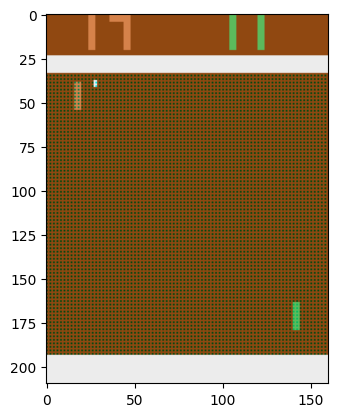

In [11]:
#agent.test.reshape(80, 80)
# plt.imshow(agent.test.reshape(80, 80))
plt.imshow(agent.test1)

In [10]:
test

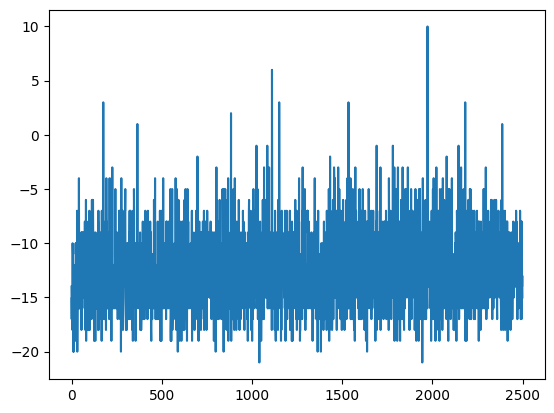

In [15]:
# plot the numbers
plt.plot(nums)
plt.show()